#### iLQR for kinematic example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

import pybullet as p
import pybullet_data

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

#### Setup pybullet with the urdf

In [2]:
# configure pybullet and load plane.urdf and quadcopter.urdf
#physicsClient = p.connect(p.DIRECT)  # pybullet only for computations no visualisation, faster
physicsClient = p.connect(p.GUI)  # pybullet with visualisation
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
p.resetSimulation()

robot_urdf = "../data/urdf/frankaemika_new/panda_arm.urdf"
robot_id = p.loadURDF(robot_urdf, useFixedBase=1)
joint_limits = get_joint_limits(robot_id, 7)

p.loadURDF('plane.urdf')

#Define the end-effector
link_id = 10
link_name = 'panda_grasptarget_hand'

#Create a ball to show the target
#_,_,ballId = create_primitives(radius=0.05)
_,_,ballId = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.3, 0.05, 0.01], rgbaColor=[1,0.4, 0,0.5])


### Construct the robot system

In [4]:
dt = 0.05
T = 100
dof = 7
sys = URDFRobot(dof=dof, robot_id=robot_id, dt = dt)

#### Find a suitable target orientation

In [33]:
qT = np.random.uniform(-1,1,7)
qT[3] -= 1
qT[5] += 1
xT = np.concatenate([qT, np.zeros(7)])
sys.set_init_state(xT)
p_target,o_target = sys.compute_ee(xT,link_id)
print("Target orientation: ",o_target)
print("Target position: ",p_target)

Target orientation:  [0.6067 0.5388 0.5805 0.0683]
Target position:  [0.2709 0.0081 0.9405]


#### Set the initial state

In [34]:
q0 = np.random.rand(7)
q0 = np.array([0.,0.,0.,-1.5,0.,1.5,0.])
#q0 = np.array([0.4201, 0.4719, 0.9226, 0.8089, 0.3113, 0.7598, 0.364 ])
x0 = np.concatenate([q0, np.zeros(7)])
sys.set_init_state(x0)
p_0,o_0 = sys.compute_ee(x0,link_id)
print("X0 orientation: ",o_0)

X0 orientation:  [ 0.9239  0.3827 -0.      0.    ]


#### Add a target visual feedback

(To visualize the target position and orientation as a box. If the EE reaches the target well, the robot EE should be at the box's center, and in a good orientation to grab the box along the short side.

In [35]:
p.resetBasePositionAndOrientation(ballId, p_target, o_target)

#### Set initial control output

In [36]:
#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [37]:
Q = np.eye(sys.Dx)*1
Q[0:sys.dof,0:sys.dof] *= 0.01  #only put cost regularization on the velocity, not on the joint angles
Qf = np.eye(sys.Dx)*1
Qf[0:sys.dof,0:sys.dof] *= 0.01 #only put cost regularization on the velocity, not on the joint angles
R = np.eye(sys.Du)*1e-9
mu = 1e-9          #regularization coefficient

#### Set the task space cost coefficients W & WT

In [38]:
W = np.diag([10,10,10])
WT = np.diag([100,100,100])
W_ori = np.diag([.1,.1,.1])
WT_ori = np.diag([1,1,1])

### iLQR using cost model

#### Define the cost

In [39]:
#The costs consist of: a) state regularization (Q), b) control regularization (R), and c) End-effector reaching task (W)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
runningStateCost = CostModelQuadratic(sys, Q)
runningControlCost = CostModelQuadratic(sys, None, R)
runningEECostPosition = CostModelQuadraticTranslation(sys,W, link_id,p_target)
runningEECostOrientation = CostModelQuadraticOrientation(sys,W_ori, link_id,o_target)
runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningEECostPosition, runningEECostOrientation])

terminalStateCost = CostModelQuadratic(sys,Qf)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalEECostPosition = CostModelQuadraticTranslation(sys,WT, link_id,p_target)
terminalEECostOrientation = CostModelQuadraticOrientation(sys,WT_ori, link_id,o_target)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalEECostPosition, terminalEECostOrientation])

costs = [runningCost]*T + [terminalCost]

#### Construct ILQR

In [40]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us) #set initial trajectory

In [41]:
ilqr_cost.mu = mu

#### Solve and Plot

In [42]:
n_iter = 30
ilqr_cost.solve(n_iter, method='recursive')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

#clear_output()

Cost converges at iteration 4, cannot decrease further


#### Play traj

In [43]:
sys.vis_traj(ilqr_cost.xs, dt = 0.01)

#### Compute Error

In [44]:
pos, quat = sys.compute_ee(ilqr_cost.xs[-1], link_id)

In [45]:
print("Position error: ", p_target - pos)
print("Absolute position error: ", np.linalg.norm(p_target - pos))

Position error:  [ 0.0013 -0.005  -0.0099]
Absolute position error:  0.011210805100015047


In [46]:
print("Orientation error: ", o_target - quat)
print("Absolute orientation error: ", np.linalg.norm(o_target - quat))

Orientation error:  [-0.1397  0.0435  0.1454 -0.0223]
Absolute orientation error:  0.20748553271763145


In [47]:
desired_orn_mat = quat2Mat( o_target )
obtained_orn_mat = quat2Mat( quat )

desired_frame = np.identity(4)
desired_frame[:3,:3] = desired_orn_mat

obtained_frame = np.identity(4)
obtained_frame[:3,:3] = obtained_orn_mat

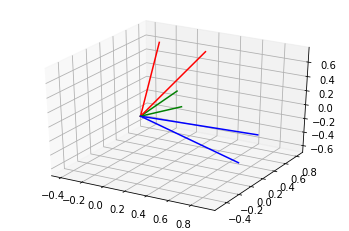

In [48]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pose_matrix(ax,desired_frame,'')
plot_pose_matrix(ax,obtained_frame,'')
set_axes_equal(ax)
plt.show()